In [11]:
import os
print(os.getcwd())


c:\data_science\notebook


# 1️⃣ Imports & Setup

In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 2️⃣ Load and Explore Data

In [ ]:
import yaml
import pandas as pd

# --- 2. CONFIG LOAD ---
with open("../config/config.yaml", "r") as f:   # ✅ путь обновлён
    config = yaml.safe_load(f)

# Extract paths and parameters
train_path = config["data"]["train_path"]
eval_path = config["data"]["eval_path"]
target_col = config["data"]["target_column"]
datetime_col = config["data"]["datetime_column"]

# --- 3. LOAD DATA ---
train = pd.read_csv(train_path)
eval = pd.read_csv(eval_path)

print("✅ Data successfully loaded!")
print(f"Training set: {train.shape}, Evaluation set: {eval.shape}")

✅ Data successfully loaded!
Training set: (4500000, 19), Evaluation set: (350000, 19)


# --- 3. LOAD DATA ---

In [36]:

train = pd.read_csv(train_path)
eval = pd.read_csv(eval_path)

print("✅ Data successfully loaded!")
print(f"Training set: {train.shape}, Evaluation set: {eval.shape}")

✅ Data successfully loaded!
Training set: (4500000, 19), Evaluation set: (350000, 19)


# 4. BASIC DATA OVERVIEW

In [18]:

print(train.head())
print(train.info())
print(train.describe())

   city_id  store_id  management_group_id  first_category_id  \
0        0         0                    0                  5   
1        0         0                    0                  5   
2        0         0                    0                  5   
3        0         0                    0                  5   
4        0         0                    0                  5   

   second_category_id  third_category_id  product_id          dt  sale_amount  \
0                   6                 65          38  2024-03-28          0.1   
1                   6                 65          38  2024-03-29          0.1   
2                   6                 65          38  2024-03-30          0.0   
3                   6                 65          38  2024-03-31          0.1   
4                   6                 65          38  2024-04-01          0.2   

                                          hours_sale  stock_hour6_22_cnt  \
0  [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0...

In [17]:
# Check missing values
print("Missing values per column:")
print(train.isna().sum())

Missing values per column:
city_id                0
store_id               0
management_group_id    0
first_category_id      0
second_category_id     0
third_category_id      0
product_id             0
dt                     0
sale_amount            0
hours_sale             0
stock_hour6_22_cnt     0
hours_stock_status     0
discount               0
holiday_flag           0
activity_flag          0
precpt                 0
avg_temperature        0
avg_humidity           0
avg_wind_level         0
dtype: int64


# 5. TARGET VARIABLE ANALYSIS

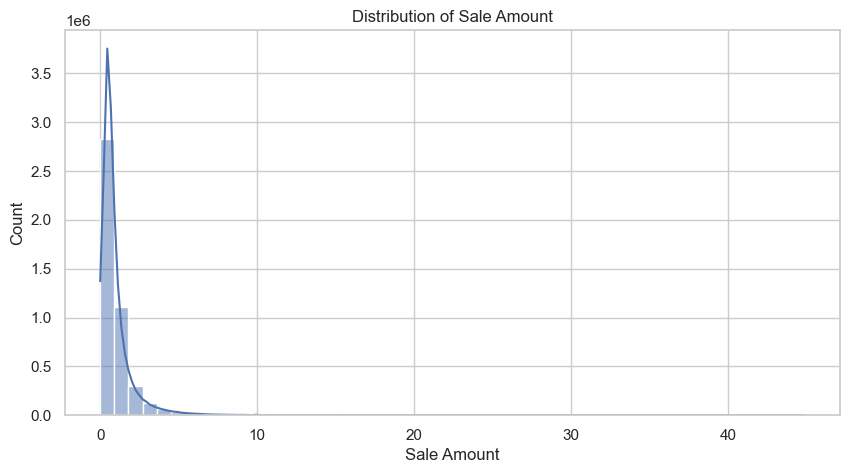

In [ ]:

# Distribution of sales
plt.figure(figsize=(10,5))
sns.histplot(train[target_col], bins=50, kde=True)
plt.title("Distribution of Sale Amount")
plt.xlabel("Sale Amount")
plt.ylabel("Count")
plt.show()


In [22]:
from scipy.stats import skew

# Basic statistics
mean_sale = train[target_col].mean()
median_sale = train[target_col].median()
std_sale = train[target_col].std()
skew_sale = skew(train[target_col])

print(f"Mean: {mean_sale:.2f}, Median: {median_sale:.2f}, Std: {std_sale:.2f}, Skewness: {skew_sale:.2f}")


Mean: 1.00, Median: 0.70, Std: 1.41, Skewness: 8.47


In [21]:
# Proportion of zero sales
zero_sales_ratio = (train[target_col] == 0).mean()
print(f"Proportion of zero sales: {zero_sales_ratio:.2%}")

Proportion of zero sales: 4.46%


# 6. TEMPORAL PATTERN ANALYSIS

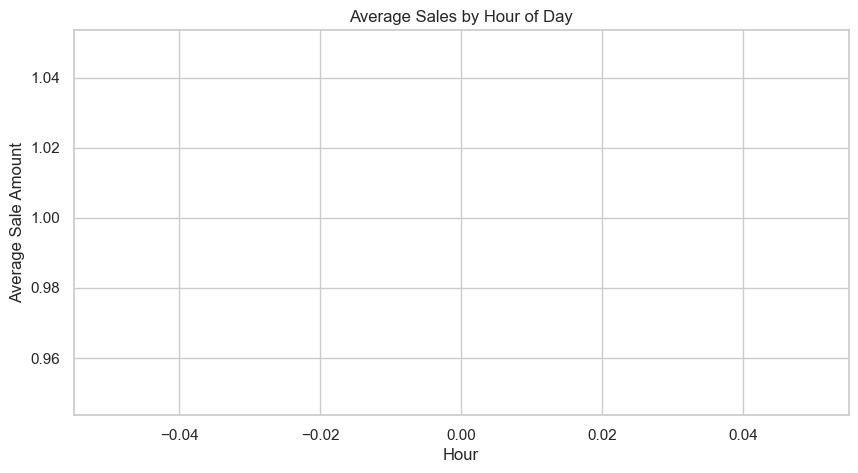

In [ ]:
# Convert datetime column
train[datetime_col] = pd.to_datetime(train[datetime_col])

# Extract hour and day of week
train['hour'] = train[datetime_col].dt.hour
train['day_of_week'] = train[datetime_col].dt.dayofweek  # 0=Monday, 6=Sunday

# Sales by hour of day
plt.figure(figsize=(10,5))
sns.lineplot(data=train.groupby('hour')[target_col].mean())
plt.title("Average Sales by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Sale Amount")
plt.show()

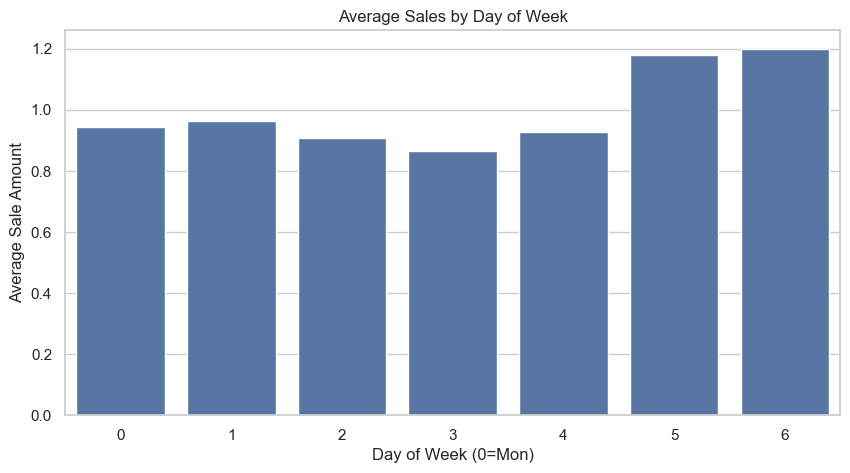

In [24]:
# Sales by day of week
plt.figure(figsize=(10,5))
sns.barplot(x='day_of_week', y=target_col, data=train.groupby('day_of_week')[target_col].mean().reset_index())
plt.title("Average Sales by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Average Sale Amount")
plt.show()



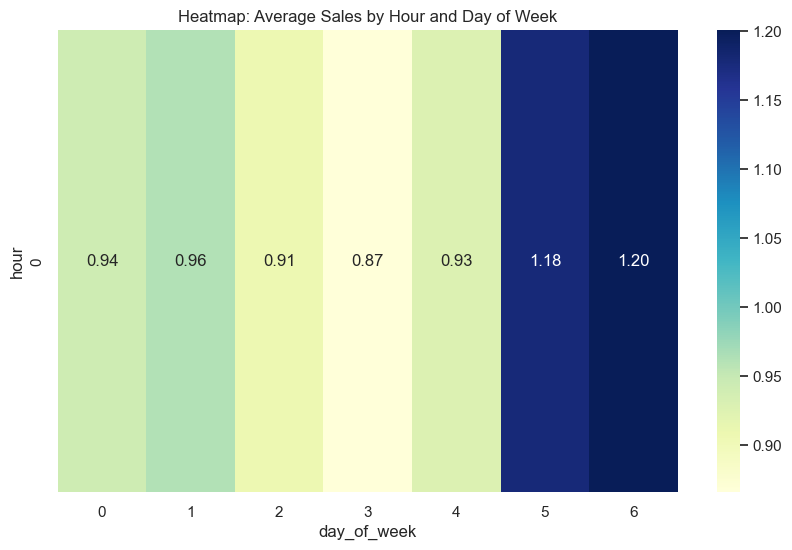

In [25]:
# Heatmap: hour vs day_of_week
sales_matrix = train.pivot_table(index='hour', columns='day_of_week', values=target_col, aggfunc='mean')
plt.figure(figsize=(10,6))
sns.heatmap(sales_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap: Average Sales by Hour and Day of Week")
plt.show()

# 7. STOCKOUT IMPACT ANALYSIS

Overall stockout rate: 0.00%
Avg sales (in-stock hours): 1.00
Avg sales (stockout hours): nan


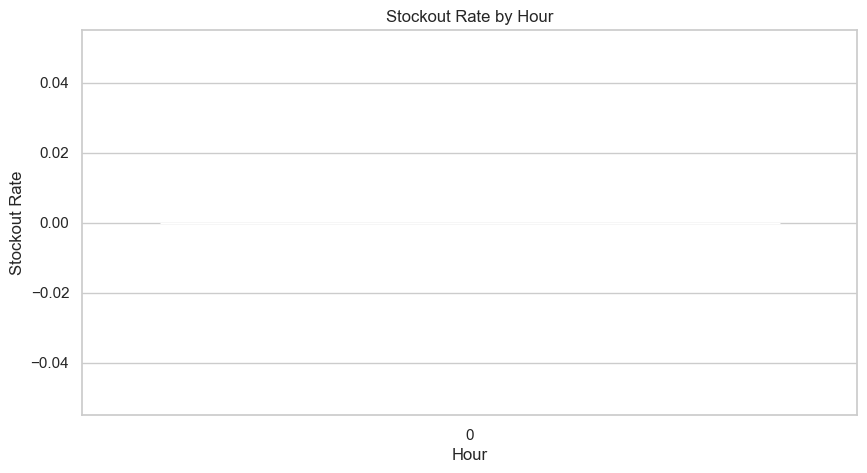

In [26]:
# Assuming stockout_flag or hours_stock_status exists
if 'hours_stock_status' in train.columns:
    train['stockout_flag'] = train['hours_stock_status'] == 0
    # Stockout rate
    stockout_rate = train['stockout_flag'].mean()
    print(f"Overall stockout rate: {stockout_rate:.2%}")

    # Average sales: in-stock vs stockout
    avg_sales_in_stock = train.loc[~train['stockout_flag'], target_col].mean()
    avg_sales_out_stock = train.loc[train['stockout_flag'], target_col].mean()
    print(f"Avg sales (in-stock hours): {avg_sales_in_stock:.2f}")
    print(f"Avg sales (stockout hours): {avg_sales_out_stock:.2f}")

    # Stockout by hour
    stockout_by_hour = train.groupby('hour')['stockout_flag'].mean()
    plt.figure(figsize=(10,5))
    sns.barplot(x=stockout_by_hour.index, y=stockout_by_hour.values)
    plt.title("Stockout Rate by Hour")
    plt.xlabel("Hour")
    plt.ylabel("Stockout Rate")
    plt.show()

# 8. ADDITIONAL INSIGHTS

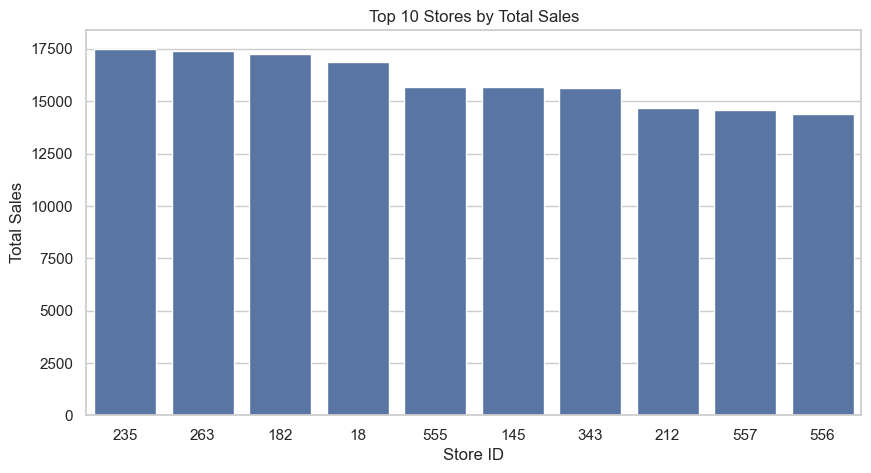

In [27]:
# Optional: visualize sales distribution by store or category
if 'store_id' in train.columns:
    top_stores = train.groupby('store_id')[target_col].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_stores.index.astype(str), y=top_stores.values)
    plt.title("Top 10 Stores by Total Sales")
    plt.xlabel("Store ID")
    plt.ylabel("Total Sales")
    plt.show()

# 9. FEATURE ENGINEERING SETUP

In [28]:
# Extract preprocessing configuration
lag_periods = config["preprocessing"]["lag_periods"]
rolling_windows = config["preprocessing"]["rolling_windows"]
seasonal_periods = config["preprocessing"]["seasonal_periods"]

print(f"Using lag periods: {lag_periods}")
print(f"Using rolling windows: {rolling_windows}")
print(f"Using seasonal periods: {seasonal_periods}")

Using lag periods: [1, 2, 3, 7, 14, 21]
Using rolling windows: [6, 24, 168]
Using seasonal periods: [24, 168]


## 9.1 Sort Data for Time Series Features

In [29]:
# Ensure data is sorted by store/product and datetime
train = train.sort_values(by=['store_id', 'product_id', datetime_col])
train.reset_index(drop=True, inplace=True)

eval = eval.sort_values(by=['store_id', 'product_id', datetime_col])
eval.reset_index(drop=True, inplace=True)

## 9.2 LAG FEATURES

In [30]:
for lag in lag_periods:
    train[f"lag_{lag}"] = train.groupby(['store_id','product_id'])[target_col].shift(lag)
    eval[f"lag_{lag}"] = eval.groupby(['store_id','product_id'])[target_col].shift(lag)

print("✅ Lag features created.")

✅ Lag features created.


## 9.3 ROLLING WINDOW FEATURES

In [31]:
for window in rolling_windows:
    train[f"roll_mean_{window}"] = train.groupby(['store_id','product_id'])[target_col].transform(lambda x: x.shift(1).rolling(window).mean())
    train[f"roll_std_{window}"] = train.groupby(['store_id','product_id'])[target_col].transform(lambda x: x.shift(1).rolling(window).std())
    
    eval[f"roll_mean_{window}"] = eval.groupby(['store_id','product_id'])[target_col].transform(lambda x: x.shift(1).rolling(window).mean())
    eval[f"roll_std_{window}"] = eval.groupby(['store_id','product_id'])[target_col].transform(lambda x: x.shift(1).rolling(window).std())

print("✅ Rolling window features created.")

✅ Rolling window features created.


## # 9.4 SEASONALITY FEATURES

In [33]:
# Extract hour from datetime
train['hour'] = pd.to_datetime(train[datetime_col]).dt.hour
eval['hour'] = pd.to_datetime(eval[datetime_col]).dt.hour

# Now create seasonal features
for period in config['preprocessing']['seasonal_periods']:
    train[f"sin_{period}"] = np.sin(2 * np.pi * train['hour']/period)
    train[f"cos_{period}"] = np.cos(2 * np.pi * train['hour']/period)
    
    eval[f"sin_{period}"] = np.sin(2 * np.pi * eval['hour']/period)
    eval[f"cos_{period}"] = np.cos(2 * np.pi * eval['hour']/period)

print("✅ Seasonal features created.")


✅ Seasonal features created.


## 9.5 OUTLIER FLAGGING

In [34]:
# 9.5 OUTLIER FLAGGING
# ===========================
outlier_threshold = config["preprocessing"].get("outlier_threshold", 3.0)

# Z-score method
train['sale_zscore'] = (train[target_col] - train[target_col].mean()) / train[target_col].std()
train['outlier_flag'] = np.abs(train['sale_zscore']) > outlier_threshold

print("✅ Outlier flags created.")

✅ Outlier flags created.


## 9.6 FEATURE SUMMARY

In [35]:
# 9.6 FEATURE SUMMARY
# ===========================
print("Feature columns preview:")
feature_cols = [col for col in train.columns if col not in [target_col, datetime_col]]
print(feature_cols[:20])  # show first 20 features

Feature columns preview:
['city_id', 'store_id', 'management_group_id', 'first_category_id', 'second_category_id', 'third_category_id', 'product_id', 'hours_sale', 'stock_hour6_22_cnt', 'hours_stock_status', 'discount', 'holiday_flag', 'activity_flag', 'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level', 'hour', 'day_of_week', 'stockout_flag']
